# Инфраструктура Python. GUI

## Qt

Самой серьезной существующей библиотекой для десктопного графического интерфейса является Qt. Она кроссплатформенная, содержит богатый набор элементов интерфейса и их настроек. В настоящее время активнее всего используются версии Qt4 и Qt5 с заметно отличающимися API. Для Python существует набор биндингов и врапперов над ними, призванных скрыть эти несовместимости и сделать их API, заточенный под C++ и свои Q`*`-классы, более pythonic. Здесь будет описана библиотека `PyQt5`, включенная в Anaconda.

Qt-приложение обрабатывает события в главном цикле — методе `QApplication.exec_`. События присылаются системой и транслируются внутри Qt в сигналы (`signal`), которые соединяются (`connect`) со слотами (`slot`), функциями-обработчиками. События крутятся вокруг набора созданных виджетов, организованных в дерево. Корневой виджет является главным окном, при завершении которого происходит выход из `exec_`.

В отдельном скрипте для запуска достаточно использовать

```python
app = QApplication([])
window = MainWindowClass()
window.show()
app.exec_()
```

Здесь же для удобства повествования будет использоваться специальная функция `run_qt_and_screenshot`, которая принимает класс-наследник `QWidget`, создает его в качестве главного окна, запускает главный цикл, а непосредственно перед закрытием главного окна и выходом делает скриншот и выводит как результат. Сюда же включено немного своей особой магии, которую IPython требует, чтобы не создавать `QApplication` несколько раз при переисполнении ячеек.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtWebKit import *
from PyQt5.QtWebKitWidgets import *

In [3]:
import PIL.Image
from io import BytesIO

pixmap = None
def run_qt_and_screenshot(WindowClass, method='pyqt5'):
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication([])

    def closeEvent(self, event):
        global pixmap
        rect = self.frameGeometry()
        dw = QDesktopWidget()
        desktop_id = dw.screen(dw.screenNumber(self)).winId()
        if method == 'pyside':
            pixmap = QPixmap.grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        elif method == 'pyqt5':
            pixmap = QApplication.primaryScreen().grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        event.accept()
        
    WindowClass.closeEvent = closeEvent
    window = WindowClass()
    window.show()

    if method == 'pyside':
        try:
            from IPython.lib.guisupport import start_event_loop_qt4
            start_event_loop_qt4(app)
        except ImportError:
            app.exec_()
    elif method == 'pyqt5':
        app.exec_()

    io = QBuffer()
    pixmap.save(io, 'PNG')
    return PIL.Image.open(BytesIO(io.data().data()))

Полезная нагрузка:

In [4]:
class MainWindow(QWidget):
    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)
        self.setWindowTitle('Hello, world')
        self.resize(320, 240)
        btn = QPushButton('Click me!', self)
        btn.clicked.connect(self.on_btn)
    def on_btn(self):
        QMessageBox.information(self, 'I\'m making a note here', 'Huge success!')

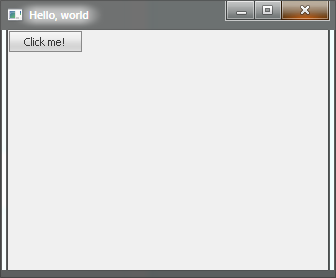

In [5]:
run_qt_and_screenshot(MainWindow)

Положение виджетов друг на друге можно настраивать вызовами `resize` или `setGeometry`, но предпочтительнее использовать лаяуты. Это контейнеры, описывающие как надо располагать виджеты внутри них, что позволяет, например, осмысленно обрабатывать изменение размера главного окна.

In [6]:
class MainWindow(QWidget):
    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)
        self.setWindowTitle('Hello, graphics')

        ilayout = QHBoxLayout()
        self.edit = QLineEdit('sin(x)')
        btn = QPushButton('Draw')
        ilayout.addWidget(self.edit)
        ilayout.addWidget(btn)

        olayout = QVBoxLayout()
        self.area = QLabel()
        olayout.addLayout(ilayout)
        olayout.addWidget(self.area)
        self.setLayout(olayout)

        btn.clicked.connect(self.redraw)
        self.redraw()

    def redraw(self):
        expr = self.edit.text()
        dpi = 96
        ioff()
        figure(figsize=(400./dpi, 300./dpi), dpi=dpi)
        x = linspace(-5, 5)
        y = eval(expr, dict([('x', x)] + numpy.__dict__.items()))
        plot(x, y)
        io = BytesIO()
        savefig(io, format='png', dpi=dpi)
        close()
        ion()
        pix = QPixmap()
        pix.loadFromData(io.getvalue())
        self.area.setPixmap(pix)

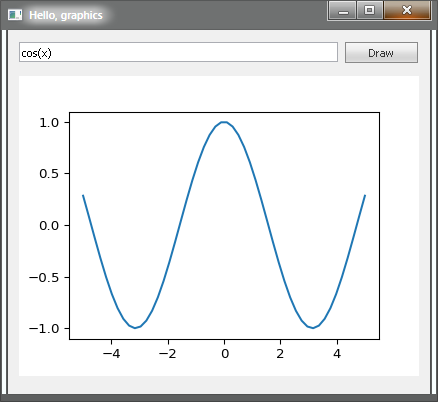

In [7]:
run_qt_and_screenshot(MainWindow)

Когда-то программа, делающая то же самое, была достойна областного конкурса исследовательских работ школьников в МАН :-) Как вариант, `matplotlib` можно встроить в Qt-приложение встроенным способом https://matplotlib.org/gallery/user_interfaces/embedding_in_qt_sgskip.html

## Иконографика

Программы и сайты часто оформляются иконками, упрощающими навигацию за счет понимания семантики некоторого пункта UI не только чтением текста, но и опознаванием стоящей рядом иконки. В настоящее время более-менее сформировался иконографический язык и его "слова" доступны в свободно распространяемых шрифтах FontAwesome (https://fontawesome.com/cheatsheet) и ElusiveIcons (http://elusiveicons.com/icons/). Их можно использовать в Qt, используя библиотеку `qtawesome`. В момент ее импорта должен быть рабочий `QApplication`.

```
pip install qtawesome
```

In [4]:
app = QCoreApplication.instance()
if app is None:
    app = QApplication([])
import qtawesome

In [13]:
def qpixmap_to_png(pixmap):
    io = QBuffer()
    pixmap.save(io, 'PNG')
    return io.data().data()

def qicon_to_png(icon):
    return qpixmap_to_png(icon.pixmap(32, 32))

get_ipython().display_formatter.formatters['image/png'].for_type(QIcon, qicon_to_png);

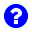

In [15]:
qtawesome.icon('fa.question-circle', color='blue', color_active='orange')

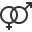

In [16]:
qtawesome.icon('fa.venus-mars')

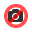

In [17]:
qtawesome.icon('fa.camera', 'fa.ban', options=[{'scale_factor': 0.5}, {'color': 'red', 'opacity': 0.7}])

In [18]:
from ultra import json_file_get

In [19]:
fn_ei = "C:\\Users\\User\\Anaconda2\\Lib\\site-packages\\qtawesome\\fonts\\elusiveicons-webfont-charmap.json"
fn_fa = "C:\\Users\\User\\Anaconda2\\Lib\\site-packages\\qtawesome\\fonts\\fontawesome-webfont-charmap.json"
names = ['ei.' + name for name in json_file_get(fn_ei).keys()] + ['fa.' + name for name in json_file_get(fn_fa).keys()]
print len(names)
print
for name in names:
    #IPython.display.display(qtawesome.icon(name))
    print name,

998

ei.comment ei.universal-access ei.photo ei.laptop ei.move ei.eye-close ei.hand-left ei.align-left ei.tasks ei.redux ei.quote-right-alt ei.caret-left ei.paper-clip-alt ei.laptop-alt ei.spotify ei.graph-alt ei.group ei.twitter ei.paper-clip ei.error-alt ei.broom ei.search-alt ei.vimeo ei.wrench-alt ei.foursquare ei.resize-vertical ei.opensource ei.th ei.folder-sign ei.th-list ei.speaker ei.deviantart ei.trash-alt ei.eur ei.random ei.flag-alt ei.video-chat ei.info-circle ei.circle-arrow-left ei.stop ei.smiley-alt ei.remove-circle ei.volume-up ei.reddit ei.idea-alt ei.facebook ei.w3c ei.compass ei.facetime-video ei.address-book ei.indent-left ei.friendfeed-rect ei.caret-up ei.trash ei.magic ei.gift ei.quotes ei.cogs ei.signal ei.list ei.upload ei.refresh ei.picasa ei.magnet ei.edit ei.viadeo ei.adjust ei.gbp ei.file-new ei.chevron-down ei.quote-alt ei.time-alt ei.glasses ei.resize-horizontal ei.arrow-down ei.heart-alt ei.delicious ei.picture ei.livejournal ei.globe ei.heart-empty ei.i

## Стили, меню, тулбар, статусбар

todo темы: есть ли симпатичные в опенсорсе? Как ставить?

есть https://github.com/ColinDuquesnoy/QDarkStyleSheet

https://wiki.qt.io/Gallery_of_Qt_CSS_Based_Styles

был когда-то qtdotnetstyle, еще до qss

Разделитель в меню, тулбар, статусбар

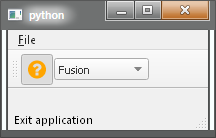

In [22]:
class MyWindow(QMainWindow):
    def __init__(self, parent=None):
        super(MyWindow, self).__init__(parent)
        exitAction = QAction(qtawesome.icon('fa.question-circle', color='blue', color_active='orange'), '&Exit', self)
        exitAction.setShortcut('Ctrl+Q')
        exitAction.setStatusTip('Exit application')
        exitAction.triggered.connect(self.close)

        self.toolbar = self.addToolBar('Exit')
        self.toolbar.addAction(exitAction)
        
        self.combo = QComboBox()
        for k in QStyleFactory.keys():
            self.combo.addItem(k)
        self.combo.currentIndexChanged.connect(self.combo_changed)
        self.toolbar.addWidget(self.combo)

        self.statusBar()

        menubar = self.menuBar()
        fileMenu = menubar.addMenu('&File')
        fileMenu.addAction(exitAction)
        
    def combo_changed(self, arg):
        app = QCoreApplication.instance()
        style = self.combo.currentText()
        app.setStyle(QStyleFactory.create(style))

run_qt_and_screenshot(MyWindow)

In [23]:
QStyleFactory.keys()

[u'Windows', u'WindowsXP', u'WindowsVista', u'Fusion']

## Грид

todo
* Как установить режим выделения, получать выделение, событие изменения выделения
* Как добавить чекбоксы в грид
* Ресайз окна очень тормозит, возможно потому что грид спрашивает data на каждый пиксель, как этого избежать?
* Длины скроллбаров на гриде неправильные

In [5]:
import sys
import operator

In [6]:
data = c_[arange(0, 1000, dtype='int').astype('object'), random.rand(1000), random.randn(1000)]

In [20]:
class NumpyArrayModel(QAbstractTableModel):
    data_calls_changed = pyqtSignal(int)
    def __init__(self, header, arr, parent=None):
        self.data_calls = 0
        assert len(arr.shape) == 2
        self.arr = arr
        self.header = header
        self.parent = parent
        super(NumpyArrayModel, self).__init__(parent)
    def headerData(self, section, orientation, role=Qt.DisplayRole):
        if orientation == Qt.Horizontal:
            if role == Qt.DisplayRole:
                return self.header[section]
        return QAbstractTableModel.headerData(self, section, orientation, role)
    def rowCount(self, parent):
        return self.arr.shape[0]
    def columnCount(self, parent):
        return self.arr.shape[1]
    def data(self, index, role):
        if role == Qt.DisplayRole:
            self.data_calls += 1
            self.data_calls_changed.emit(self.data_calls)
            return str(self.arr[index.row(), index.column()])
        if role == Qt.ForegroundRole and index.column() == 2:
            return QBrush(Qt.darkRed if self.arr[index.row(), index.column()] < 0 else Qt.darkGreen)
        return None
    def sort(self, Ncol, order):
        self.layoutAboutToBeChanged.emit()
        if Ncol == 2:
            self.arr = array(sorted(self.arr, key=lambda x:abs(x[2])))
        else:
            self.arr = array(sorted(self.arr, key=operator.itemgetter(Ncol)))
        if order == Qt.DescendingOrder:
            self.arr = self.arr[::-1]
        self.layoutChanged.emit()

In [21]:
class MainWindow(QWidget):
    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)
        self.setWindowTitle('Hello, widgets')
        self.resize(640, 400)
        
        hbox = QHBoxLayout(self)

        vbox = QVBoxLayout()
        self.lbl = QLabel("foo")
        vbox.addWidget(self.lbl)
        vbox.addSpacerItem(QSpacerItem(1, 2))
        cmd = QPushButton("Click me")
        vbox.addWidget(cmd)
        import qtawesome
        
        cmd2 = QPushButton(qtawesome.icon('fa.question-circle', color='blue', color_active='orange'), "Help")
        vbox.addWidget(cmd2)
        #cmd.clicked.connect(someFunc)
        hbox.addLayout(vbox)

        txt = QTextEdit()
        hbox.addWidget(txt)
        txt.setText("Input there")

        self.model = NumpyArrayModel(['Index', 'Uniform', 'Normal'], data)
        self.model.data_calls_changed.connect(self.data_calls)
        
        self.tbl = QTableView()
        self.tbl.setMinimumWidth(300)
        self.tbl.setModel(self.model)
        self.tbl.verticalHeader().hide()
        self.tbl.verticalHeader().setSectionResizeMode(QHeaderView.Fixed)
        self.tbl.verticalHeader().setDefaultSectionSize(16)
        self.tbl.horizontalHeader().setAlternatingRowColors(True)
        self.tbl.resizeColumnsToContents()
        self.tbl.setSortingEnabled(True)
        self.tbl.setAlternatingRowColors(True)

        self.tbl.setSelectionBehavior(QTableView.SelectRows)
        self.tbl.setSelectionMode(QTableView.SingleSelection)

        selectionModel = self.tbl.selectionModel()
        selectionModel.selectionChanged.connect(lambda: self.selection_changed(selectionModel.selectedRows()))

        hbox.addWidget(self.tbl)

        self.wv = QWebView()
        #self.wv.load(QUrl("http://yandex.ru"))
        self.wv.setHtml('<b>Hello, <a href="http://google.com">world</a>!</b>')
        hbox.addWidget(self.wv)

    def data_calls(self, num):
        self.lbl.setText(str(num))
    def selection_changed(self, selected):
        html = 'Row: <b>%d</b>, column: <b>%d</b>' % (selected[0].row(), selected[0].column())
        self.wv.setHtml(html)

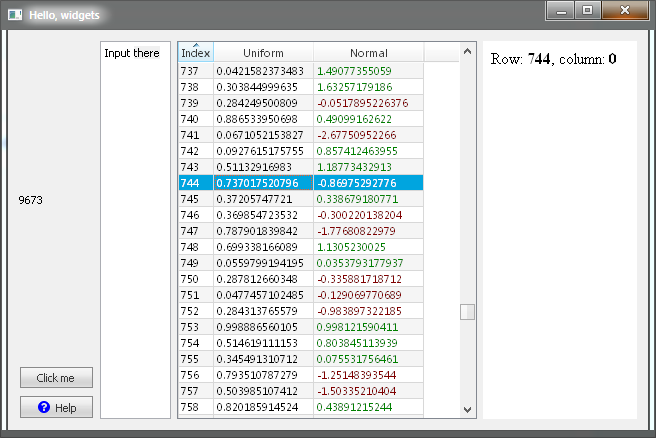

In [22]:
run_qt_and_screenshot(MainWindow)

## Дерево

todo дерево:драгндроп, обработка смены выделения, показывать развернутым

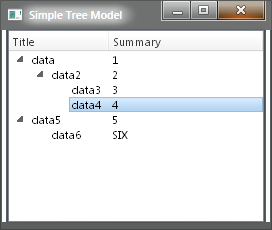

In [24]:
class TreeItem(object):
    def __init__(self, data, parent=None):
        self.parentItem = parent
        self.itemData = data
        self.childItems = []

    def appendChild(self, item):
        self.childItems.append(item)

    def child(self, row):
        return self.childItems[row]

    def childCount(self):
        return len(self.childItems)

    def columnCount(self):
        return len(self.itemData)

    def data(self, column):
        try:
            return self.itemData[column]
        except IndexError:
            return None

    def parent(self):
        return self.parentItem

    def row(self):
        if self.parentItem:
            return self.parentItem.childItems.index(self)
        return 0


class TreeModel(QAbstractItemModel):
    def __init__(self, data, parent=None):
        super(TreeModel, self).__init__(parent)
        self.rootItem = TreeItem(("Title", "Summary"))
        import re
        parents = [self.rootItem]
        indentations = [0]
        for line in data.splitlines():
            position = len(re.match('\s*', line).group())
            lineData = line[position:].strip()
            columnData = lineData.split('\t')
            if position > indentations[-1]:
                # The last child of the current parent is now the new
                # parent unless the current parent has no children.
                if parents[-1].childCount() > 0:
                    parents.append(parents[-1].child(parents[-1].childCount() - 1))
                    indentations.append(position)
            else:
                while position < indentations[-1] and len(parents) > 0:
                    parents.pop()
                    indentations.pop()
            parents[-1].appendChild(TreeItem(columnData, parents[-1]))

    def columnCount(self, parent):
        parentItem = parent.internalPointer() if parent.isValid() else self.rootItem
        return parentItem.columnCount()
    def rowCount(self, parent):
        if parent.column() > 0: return 0
        parentItem = parent.internalPointer() if parent.isValid() else self.rootItem
        return parentItem.childCount()

    def headerData(self, section, orientation, role):
        if orientation == Qt.Horizontal and role == Qt.DisplayRole:
            return self.rootItem.data(section)
        return None
    def data(self, index, role):
        if not index.isValid(): return None
        if role != Qt.DisplayRole: return None
        item = index.internalPointer()
        return item.data(index.column())

    def flags(self, index):
        if not index.isValid(): return Qt.NoItemFlags
        return Qt.ItemIsEnabled | Qt.ItemIsSelectable

    def index(self, row, column, parent):
        if not self.hasIndex(row, column, parent): return QModelIndex()
        parentItem = parent.internalPointer() if parent.isValid() else self.rootItem
        childItem = parentItem.child(row)
        if not childItem: return QModelIndex()
        return self.createIndex(row, column, childItem)

    def parent(self, index):
        if not index.isValid(): return QModelIndex()
        childItem = index.internalPointer()
        parentItem = childItem.parent()
        if parentItem == self.rootItem: return QModelIndex()
        return self.createIndex(parentItem.row(), 0, parentItem)


model = TreeModel('''data\t1
 data2\t2
  data3\t3
  data4\t4
data5\t5
 data6\tSIX''')

class MyTreeView(QTreeView):
    def __init__(self, parent=None):
        super(MyTreeView, self).__init__(parent)
        self.setModel(model)
        self.setWindowTitle("Simple Tree Model")
        self.expandAll()

run_qt_and_screenshot(MyTreeView)

In [25]:
print ' '.join(dir(QTreeView))

AboveItem AdjustIgnored AdjustToContents AdjustToContentsOnFirstShow AllEditTriggers AnimatingState AnyKeyPressed BelowItem Box CollapsingState ContiguousSelection CurrentChanged CursorAction DoubleClicked DragDrop DragDropMode DragOnly DragSelectingState DraggingState DrawChildren DrawWindowBackground DropIndicatorPosition DropOnly EditKeyPressed EditTrigger EditTriggers EditingState EnsureVisible ExpandingState ExtendedSelection HLine IgnoreMask InternalMove MoveDown MoveEnd MoveHome MoveLeft MoveNext MovePageDown MovePageUp MovePrevious MoveRight MoveUp MultiSelection NoDragDrop NoEditTriggers NoFrame NoSelection NoState OnItem OnViewport PaintDeviceMetric Panel PdmDepth PdmDevicePixelRatio PdmDevicePixelRatioScaled PdmDpiX PdmDpiY PdmHeight PdmHeightMM PdmNumColors PdmPhysicalDpiX PdmPhysicalDpiY PdmWidth PdmWidthMM Plain PositionAtBottom PositionAtCenter PositionAtTop Raised RenderFlag RenderFlags ScrollHint ScrollMode ScrollPerItem ScrollPerPixel SelectColumns SelectItems SelectR

## Scintilla

Самым популярным компонентом для подсвеченного текста является Scintilla, которую использует, например, Notepad++. Для Qt существует враппер с Python-оберткой в свою очередь для него. Хороший обзор QScintilla можно найти здесь https://qscintilla.com/

http://pyqt.sourceforge.net/Docs/QScintilla2/classQsciLexer.html

https://qscintilla.com/downloads/qscintilla_docs.pdf

https://scintilla.org/ScintillaDoc.html

```
conda install -c cogsci qscintilla2
```

todo
```
SCI_STYLESETFONT(int style, const char *fontName)
SCI_STYLESETSIZE(int style, int sizePoints)
SCI_STYLESETBOLD(int style, bool bold)
SCI_STYLESETITALIC(int style, bool italic)
SCI_STYLESETUNDERLINE(int style, bool underline)
SCI_STYLESETFORE(int style, colour fore)
SCI_STYLESETBACK(int style, colour back)
SCI_STYLESETCHANGEABLE(int style, bool changeable)
SCI_STYLESETHOTSPOT(int style, bool hotspot)
```

In [34]:
print QsciLexerPython().lexer(), QsciLexerPython().language(), QsciLexerPython().description(4)

python Python Single-quoted string


In [35]:
print QsciLexerPython.Comment, QsciLexerPython.Number

1 2


In [31]:
from PyQt5.Qsci import QsciScintilla, QsciLexerPython

In [27]:
import xmltodict
from ultra import file_get

theme = xmltodict.parse(file_get("C:\\Program Files (x86)\\Notepad++\\themes\\Solarized-light.xml"))

style = [
    lexer_record['WordsStyle']
    for lexer_record in theme['NotepadPlus']['LexerStyles']['LexerType']
    if lexer_record['@name'] == 'python'
][0]

global_style = theme['NotepadPlus']['GlobalStyles']['WidgetStyle']

todo

* менять стрелку влево на стрелку вправо на Margin?
* collapsed-expanded
* ссылки, обработка кликов на них
* интеллисенс?
* получение выделения
* установление курсора/скролла, выделения
* подсветка таких же выделенных слов
* выделенный в Notepad++ текст имеет цвета, а у меня всегда белый
* Настройки Scintilla из Notepad++?
* Как прикрутить лексеры из Notepad++? pygments? Как подсвечивать синтаксис вставленных в текст блоков кода на разных языках?

In [12]:
for item in dir(QsciScintilla):
    print item,

ANNOTATION_BOXED ANNOTATION_HIDDEN ANNOTATION_INDENTED ANNOTATION_STANDARD AcsAPIs AcsAll AcsDocument AcsNone AcusAlways AcusExplicit AcusNever AdjustIgnored AdjustToContents AdjustToContentsOnFirstShow AiClosing AiMaintain AiOpening AnnotationBoxed AnnotationDisplay AnnotationHidden AnnotationIndented AnnotationStandard AutoCompletionSource AutoCompletionUseSingle Background Bookmark BottomLeftCorner Box BoxIndicator BoxedFoldStyle BoxedMinus BoxedMinusConnected BoxedPlus BoxedPlusConnected BoxedTreeFoldStyle BraceMatch CARETSTYLE_BLOCK CARETSTYLE_INVISIBLE CARETSTYLE_LINE CARET_EVEN CARET_JUMPS CARET_SLOP CARET_STRICT CallTipsAboveText CallTipsBelowText CallTipsContext CallTipsNoAutoCompletionContext CallTipsNoContext CallTipsNone CallTipsPosition CallTipsStyle Circle CircledFoldStyle CircledMinus CircledMinusConnected CircledPlus CircledPlusConnected CircledTreeFoldStyle DashesIndicator DiagonalIndicator DotBoxIndicator DotsIndicator DownTriangle DrawChildren DrawWindowBackground ED

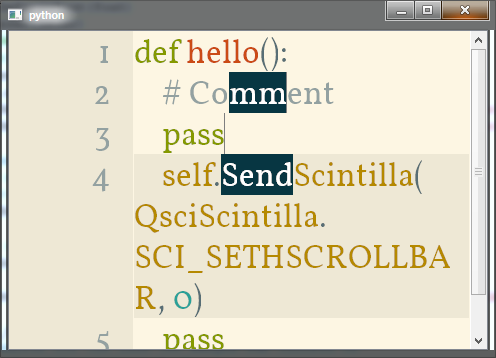

In [33]:
class SimplePythonEditor(QsciScintilla):
    ARROW_MARKER_NUM = 8

    def __init__(self, parent=None):
        super(SimplePythonEditor, self).__init__(parent)

        self.setUtf8(True)
        self.setWrapMode(QsciScintilla.WrapWord)
        self.setIndentationsUseTabs(False)
        #self.setIndentationGuides(True) # вертикальные полоски на каждом табе
        self.setTabWidth(4)
        self.setAutoIndent(True)
        
        # Set the default font
        font = QFont()
        font.setFamily('Vollkorn')
        font.setFixedPitch(True)
        font.setPointSize(24)
        self.setFont(font)

        # Margin 0 is used for line numbers
        fontmetrics = QFontMetrics(font)
        self.setMarginsFont(font)
        self.setMarginWidth(0, fontmetrics.width("00000") + 6)
        self.setMarginLineNumbers(0, True)

        # Clickable margin 1 for showing markers
        self.setMarginWidth(1, fontmetrics.width("0"))
        self.setMarginSensitivity(1, True)
        self.marginClicked.connect(self.on_margin_clicked)
        self.markerDefine(QsciScintilla.RightArrow, self.ARROW_MARKER_NUM)
        self.setMarkerBackgroundColor(QColor("#ee1111"), self.ARROW_MARKER_NUM)

        # Brace matching: enable for a brace immediately before or after the current position
        self.setBraceMatching(QsciScintilla.SloppyBraceMatch)
        self.setMatchedBraceBackgroundColor(Qt.yellow);

        self.setCaretLineVisible(True)
        for item in global_style:
            fg = QColor('#' + item['@fgColor']) if '@fgColor' in item else None
            bg = QColor('#' + item['@bgColor']) if '@bgColor' in item else None
            if item['@name'] == 'Current line background colour':
                self.setCaretLineBackgroundColor(bg)
            elif item['@name'] == 'Selected text colour':
                self.setSelectionBackgroundColor(bg)
            elif item['@name'] == 'Line number margin':
                self.setMarginsBackgroundColor(bg)
                self.setMarginsForegroundColor(fg)
            elif item['@name'] == 'Caret colour':
                self.setCaretForegroundColor(fg)
            elif item['@name'] == 'Brace highlight style':
                self.setMatchedBraceBackgroundColor(bg)
                self.setMatchedBraceForegroundColor(fg)
            elif item['@name'] == 'Bad brace colour':
                self.setUnmatchedBraceBackgroundColor(bg)
                self.setUnmatchedBraceForegroundColor(fg)
        
        lexer = QsciLexerPython()
        lexer.setDefaultFont(font)
        self.setLexer(lexer)
        for item in style:
            if int(item['@styleID']) == 0:
                lexer.setPaper(QColor('#' + item['@bgColor']))
            lexer.setFont(font, int(item['@styleID']))
            self.SendScintilla(QsciScintilla.SCI_STYLESETBACK, int(item['@styleID']), QColor('#' + item['@bgColor']))
            self.SendScintilla(QsciScintilla.SCI_STYLESETFORE, int(item['@styleID']), QColor('#' + item['@fgColor']))

        # Hide horizontal scrollbar by raw message to Scintilla
        self.SendScintilla(QsciScintilla.SCI_SETHSCROLLBAR, 0)

        self.setMinimumSize(480, 320)
        
        self.setText('def hello():\n\t# Comment\n\tpass\n\tself.SendScintilla(QsciScintilla.SCI_SETHSCROLLBAR, 0)\n\tpass')

    def on_margin_clicked(self, nmargin, nline, modifiers):
        # Toggle marker for the line the margin was clicked on
        if self.markersAtLine(nline) != 0:
            self.markerDelete(nline, self.ARROW_MARKER_NUM)
        else:
            self.markerAdd(nline, self.ARROW_MARKER_NUM)
            
    def wheelEvent(self, event):
        if QApplication.keyboardModifiers() & Qt.ControlModifier:
            if event.angleDelta().y() > 0:
                self.zoomIn()
            else:
                self.zoomOut()
        else:
            super(SimplePythonEditor, self).wheelEvent(event)
        
run_qt_and_screenshot(SimplePythonEditor)

todo uic
```
from PyQt4 import uic
uic.loadUi("main.ui", self) и все

pyuic5 main.ui -o main.py
```

todo Как что-нибудь рисовать?

todo как проигрывать видео? нужен видеоплеер -- QtAV? https://github.com/wang-bin/QtAV -- Qt+ffmpeg, не нашел питон-биндингов, ждем https://github.com/wang-bin/QtAV/pull/1082/commits -- смерджили!

стриминг stream.send_to_rtmp_server(original_video) - что это?


todo pyqtgraph? http://www.pyqtgraph.org/ PyQtGraph is a pure-python graphics and GUI library built on PyQt4 / PySide and numpy.

todo pyglet?

todo Нужны сплиттер, иконка окна, Докающиеся субокна?

todo RichEdit?

todo VB6: Label, QLineEdit, QTextEdit, Frame, Combo (как устанавливать значение?), OptionButton, Checkbox
    QTextEdit()
        .setText(text)

    checkBox = QtGui.QCheckBox('Enlarge Window', self)
    checkBox.toggle()
    checkBox.stateChanged.connect(self.enlarge_window)
    def enlarge_window(self, state):
        if state == QtCore.Qt.Checked:



todo OpenFile, OpenFolder dialogs
    QFontDialog.getFont()
    QColorDialog.getColor()
    QFileDialog.getOpenFileName(self, 'Open File')
    QFileDialog.getSaveFileName(self, 'Save File')

todo Календарь
    QCalendarWidget

todo Табы, прогрессбар, слайдер
    QProgressBar
    self.progress.setValue(self.completed)

todo отдельно QWebView, перехватывать переходы по ссылкам

    void MainWindow::downloadRequested(
         const QNetworkRequest &request)
    {
    // First prompted with a file dialog to make sure
    // they want the file and to select a download
    // location and name.
    QString defaultFileName =
     QFileInfo(request.url().toString()).fileName();
    QString fileName =
     QFileDialog::getSaveFileName(this,
                                  tr("Save File"),
                                  defaultFileName);
    if (fileName.isEmpty())
     return;

    // Construct a new request that stores the
    // file name that should be used when the
    // download is complete
    QNetworkRequest newRequest = request;
    newRequest.setAttribute(QNetworkRequest::User,
                           fileName);

    // Ask the network manager to download
    // the file and connect to the progress
    // and finished signals.
    QNetworkAccessManager *networkManager =
     webView->page()->networkAccessManager();
    QNetworkReply *reply =
     networkManager->get(newRequest);
    connect(
     reply, SIGNAL(downloadProgress(qint64, qint64)),
     this, SLOT(downloadProgress(qint64, qint64)));
    connect(reply, SIGNAL(finished()),
           this, SLOT(downloadIssueFinished()));
    }


todo Обработка драгндропа

todo self.setWindowIcon(QtGui.QIcon('pythonlogo.png'))